In [1]:
!apt-get install -y git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!git clone https://github.com/Ajoke23/eos2ta5-model-validation.git

Cloning into 'eos2ta5-model-validation'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 116 (delta 11), reused 0 (delta 0), pack-reused 91
Receiving objects: 100% (116/116), 3.51 MiB | 4.43 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
!pip install rdkit
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=738d170ed0ba3fa90238dac0cf4e55f73154620ccb960bb6015dc1d2e6055917
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
import os
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from umap import UMAP

In [5]:

# Navigating the data path
%cd eos2ta5-model-validation/Data/Output

df = pd.read_csv("1000molecules_prediction.csv")

# Display the first few rows of the DataFrame
print(df.head())


/content/eos2ta5-model-validation/Data/Output
                           key                 input  probability
0  BPBPYQWMFCTCNG-UHFFFAOYSA-N    CCC(C)SSc1ncc[nH]1     0.045704
1  ZRWPUFFVAOMMNM-UHFFFAOYSA-N  O=C1C=C2C(=CCOC2O)O1     0.037851
2  XZWYZXLIPXDOLR-UHFFFAOYSA-N     CN(C)C(=N)N=C(N)N     0.097792
3  CUVLMZNMSPJDON-UHFFFAOYSA-N     CCCCOCC(C)OCC(C)O     0.338173
4  NRZWYNLTFLDQQX-UHFFFAOYSA-N  CCC(C)(C)c1ccc(O)cc1     0.275217


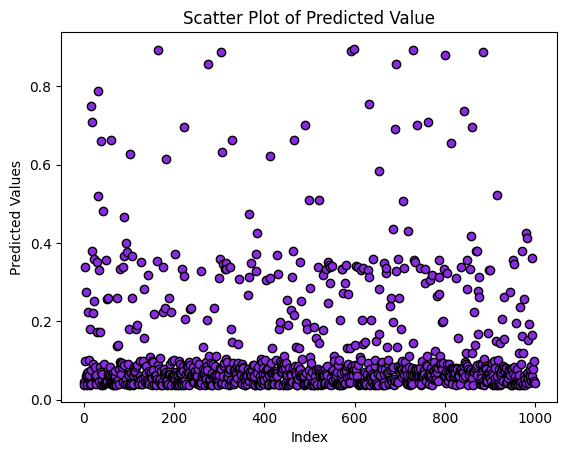

In [6]:
# plotting a scatter plot for the predicted value
plt.scatter(df.index, df['probability'],edgecolors='black', facecolors='#8A2BE2')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted Value')

plt.savefig('scatterplot.png')


Due to the objectives of study, i will be setting threshold probability above which a
compound is considered to inhibit hERG. If the predicted value is >=0.5, it is considered
**hERG blocker** and predicted value <0.5 is considered **hERG nonblocker**

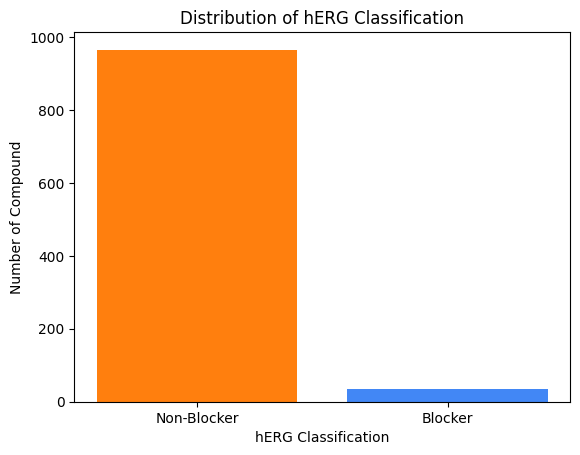

In [7]:

# Setting hERG threshold
threshold = 0.5

# Classification of compound based on threshold probability
df['hERG_classification'] = df['probability'].apply(lambda x: 'Blocker' if x >= threshold else 'Non-Blocker')

# Number of compound in each class
class_counts = df['hERG_classification'].value_counts()

# color presentation for the classifaction in hex format
colors = {'Blocker': '#4287f5', 'Non-Blocker': '#ff7f0e'}

# bar plot to show hERG classification
plt.bar(class_counts.index, class_counts.values, color=[colors[class_] for class_ in class_counts.index])
plt.xlabel('hERG Classification')
plt.ylabel('Number of Compound')
plt.title('Distribution of hERG Classification')
plt.show()


In [8]:
print("Based on the plot, we observe the following:")
print("There are {} compounds classified as hERG Blockers.".format(class_counts['Blocker']))
print("There are {} compounds classified as hERG Non-Blockers.".format(class_counts['Non-Blocker']))

Based on the plot, we observe the following:
There are 35 compounds classified as hERG Blockers.
There are 965 compounds classified as hERG Non-Blockers.


This visualization above is used to know distribution of our molecules that are **hERG Blocker** and **hERG Non-blockers** in the dataset.
From the plot, 95% of the molecules are Non-blockers while 5% of the molecules are blocker.


**SCATTER PLOT WITH TWO NUMERICAL DATA**

Since our predicted output only has one numerical data. To further explore hERG blocker and hERG nonblocker, I would love to implement a  scatter plot with two numerical data which I believe with give better insight.
To achieve this case, I will be featurizing the **input** columns which is in Standardized smiles by using **Morgan Fingerprint** and also reduce the dimensionality features using **Principal Component Analysis (PCA)** and **UMAP**

In [9]:
# Calculate Morgan fingerprints
def calculate_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)  # Morgan fingerprint radius=2, bit length=1024
        return list(fp)
    else:
        return None
#Apply to the input column a nd retun a column named "Morgan Fingerprint"
df['morgan_fingerprint'] = df['input'].apply(calculate_morgan_fingerprint)



[05:54:25] WARNING: not removing hydrogen atom without neighbors
[05:54:26] WARNING: not removing hydrogen atom without neighbors
[05:54:26] WARNING: not removing hydrogen atom without neighbors
[05:54:26] WARNING: not removing hydrogen atom without neighbors
[05:54:26] WARNING: not removing hydrogen atom without neighbors


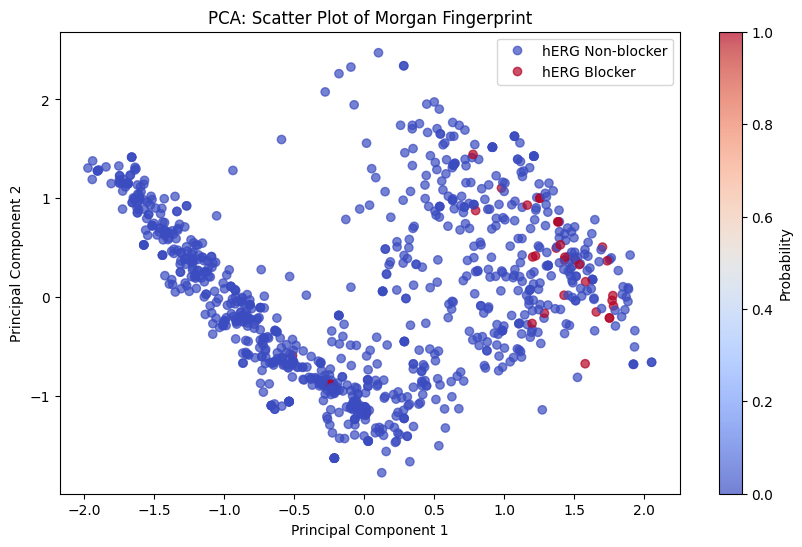

In [22]:

# PCA on Morgan fingerprints
X = df['morgan_fingerprint'].tolist()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['probability']>=0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Scatter Plot of Morgan Fingerprint')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']
plt.legend(handles=scatter.legend_elements()[0],labels=legend_labels)

#show the plot
plt.show()


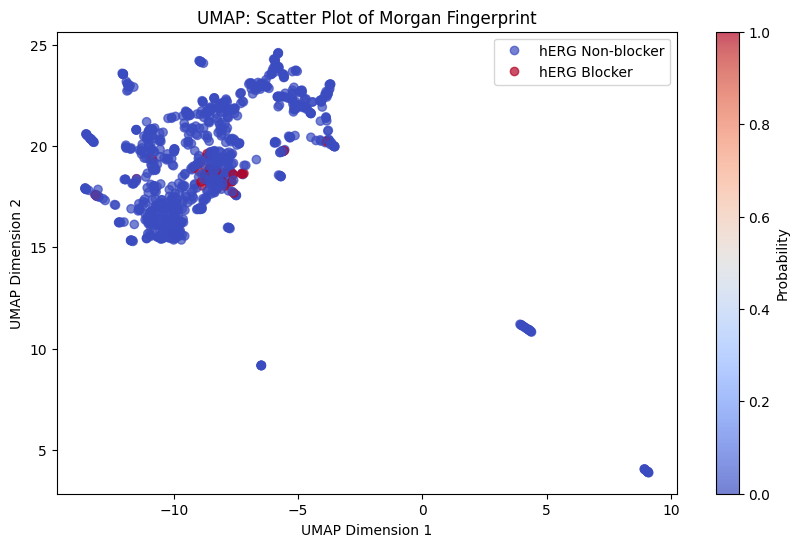

In [20]:
from umap import UMAP
#UMAP for dimensionality reduction
X = df['morgan_fingerprint'].tolist()
mapper = UMAP(n_components=2)
X_umap = mapper.fit_transform(X)

# Plot the scatter plot with legend
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['probability'] >= 0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP: Scatter Plot of Morgan Fingerprint')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

#show the plot
plt.show()

